# Simple cadCAD Template

This is a template that will allow you to start a cadCAD experiment without needing to fork another project.

## Check cadCAD

This cell doesn't do anything, but it does ensure that you know what version of cadCAD you're running. That way if/when you encounter technical difficulties you can tell the community which version of cadCAD you're running. Might save you hours of pain if all you need to do is upgrade to the latest version. 

In [18]:
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /usr/local/lib/python3.8/site-packages
Requires: pandas, funcy, pathos, fn
Required-by: cadCAD-diagram
Note: you may need to restart the kernel to use updated packages.


## Import Stuff

These are the libraries you'll need (cadCAD stuff) and that could be useful (python stuff) for your cadCAD model.

We're using [cadCAD Diagram](https://github.com/cadCAD-org/cadCAD_diagram), which is separate from cadCAD. If you're using the VS Code container from this repo it's already installed, but otherwise you might need to instal it.

In [19]:
# Python
import numpy as np
import random as random

# cadCAD
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor
from cadCAD_diagram import diagram_from_config

# Notebook setup
experiment = Experiment()
del configs[:]

## Initial Params

These are the parameters that control the behavior of a system. For example, if you were modeling a Web3 protocol these would be the parameters within a system that token holders could vote to modify. All of the parameters of a protocol that can be modified should be accessible here. That way it's easy to modify and run similations to explore how parameter changes might affect the network.

In [20]:
# The initial state of the system
genesis_states = {
    # A state variable
    'stuff': 1,
    # Another state variable
    'things': 100
}

# The parameters to run the model
params = {
    # System parameters
    'M': {
        'param_1': [2],
        'param_2': [7]
    },
    # Timesteps per run
    'T': range(100),
    # Number of parallel runs
    'N': 3
}

## Policy Functions

Policy functions are like flows in stock and flow diagrams. They modify the inputs to state update functions.

In [21]:
# We start policy functions with p_ so that they're easier to keep track of
# when we put them into state update blocks. 
def p_data_point(params, step, sH, s):
    # Variables
    p1 = params['param_1']
    things = s['things']
    random_int = np.random.randint(1, things)

    # Logic
    # a data point that's useful for something
    data_point = random_int * p1

    # Output
    # returns a python dictionary item
    return ({'data_point': data_point})


## State Update Functions

These functions take in inputs (state variables and policies) and modify the state.

In [22]:
# We start state update functions with s_ so that they're easier to keep track of
# when we put them into state update blocks. 
def s_modify_state(params, step, sH, s, _input):
    # Variables
    y = 'stuff'
    x = s[y]
    
    # Logic
    add_stuff = round(s['things'] / _input['data_point']) + params['param_2']
    x += add_stuff
    
    # Output
    return (y, x)


## State Update Block

If you're approaching cadCAD from Web3 you can think of the state of the model as something that evolves in blocks. Each block has a set of actions that updates the state. Those transactions then get batched into blocks to be processed together. In cadCAD blocks are called "`partial_state_update_blocks`." As you can see below, this is an array that is very similar to a "block" in a blockchain in that it represents a set of actions to update the state. That state is then updated across many timesteps. This is similar to how the state of a blockchain is updated over many timesteps as new blocks are added.



In [23]:
partial_state_update_blocks = [
    {
        'label': 'Example State Update Block',
        # policies represent the behavior of agents that interact with components of the system
        'policies': { 
            'data_point': p_data_point
        },
        # state variables that will be updated
        'variables': {
            'stuff': s_modify_state
        }
    }
]

## Running the cadCAD Engine

In [24]:
experiment.append_configs(
    initial_state = genesis_states,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = config_sim(params)
)

exec_mode = ExecutionMode()
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs) 
raw_system_events, tensor_field, sessions = simulation.execute() 


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 2, 3, 2)
Execution Method: local_simulations
SimIDs   : [0, 0, 0]
SubsetIDs: [0, 0, 0]
Ns       : [0, 1, 2]
ExpIDs   : [0, 0, 0]
Execution Mode: parallelized
Total execution time: 0.07s


## Data Visualization

This is often half the battle. Not only do need to design and build a cadCAD model, but you need to understand how it's working and be able to effectively communicate that to other people. A picture says a thousand words, thus enter data viz. Getting good at using python data viz libraries is probably the highest leverage thing you can do after you learn the cadCAD basics.

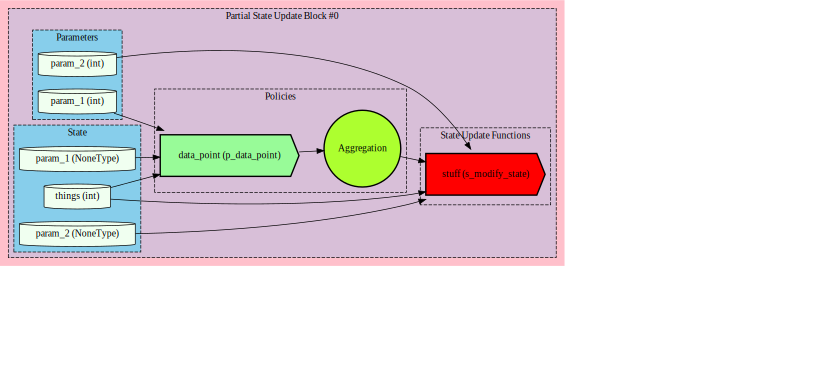

In [25]:
diagram_from_config(configs[0])

In [26]:
%matplotlib inline
import pandas as pd
simulation_result = pd.DataFrame(raw_system_events)
simulation_result.set_index(['subset', 'run', 'timestep', 'substep'])

stuff  things  simulation
subset run timestep substep                           
0      1   0        0            1     100           0
           1        1            9     100           0
           2        1           17     100           0
           3        1           25     100           0
           4        1           33     100           0
...                            ...     ...         ...
       3   96       1          975     100           0
           97       1          983     100           0
           98       1          991     100           0
           99       1          999     100           0
           100      1         1007     100           0

[303 rows x 3 columns]

<AxesSubplot:xlabel='timestep'>

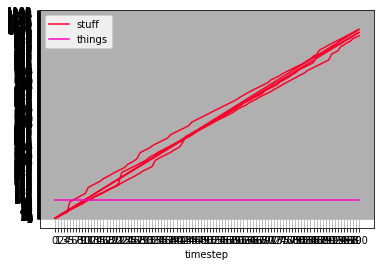

In [17]:
simulation_result.plot('timestep', ['stuff', 'things'], grid=True, 
        colormap = 'gist_rainbow',
        xticks=list(simulation_result['timestep'].drop_duplicates()), 
        yticks=list(range(1+(simulation_result['stuff']+simulation_result['things']).max())))